### ライブラリのインストール
必要なライブラリをインストールし、実行環境のバージョンを統一します。

In [1]:
import sys

# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # ライブラリのインストール
    # 元のコードに numpy のインストールを追加
    print("Installing libraries for Google Colab...")
    %pip install --no-warn-conflicts torch==2.1.1 torchvision==0.16.1 nltk==3.8.1 janome==0.5.0 numpy
    print("Installation complete.")
else:
    print("Not Google Colab")

Installing libraries for Google Colab...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━

### ドライブのマウント

In [2]:
# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # マウントを行う
    from google.colab import drive

    drive.mount("/content/drive")
else:
    print("Not Google Colab")

Mounted at /content/drive


### ライブラリのインポート

In [3]:
import copy
import io
import os
import math
import re
import tarfile
import time
import urllib.request
from typing import Optional

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from janome.tokenizer import Tokenizer
from nltk import tokenize
from sklearn.model_selection import train_test_split


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

### 改善モデル (Self-Attention + GRU)

In [19]:
import torch
import torch.nn as nn

class Attention_GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_heads=8):
        super(Attention_GRU_Model, self).__init__()

        # 1. Embedding層
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # 2. Attention層 (Multi-Head Atttenion)
        self.multi_head_attention = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            batch_first=False # 入力の形式を (seq_len, batch_size, dim) に指定
        )

        #  学習を安定させるための正規化層
        self.norm1 = nn.LayerNorm(embedding_dim)

        # 3. GRU層
        self.gru = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)

        # 4. 全結合層
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x の形状: (batch_size, seq_len) -> (16, 512)

        # 1. Embedding
        x = self.embedding(x)  # -> (16, 512, embedding_dim)

        # 2. Self-Attention
        # MultiheadAttentionの入力形式 (seq_len, batch_size, dim) に合わせる
        x_permuted = x.permute(1, 0, 2) # -> (512, 16, embedding_dim)

        attn_output, _ = self.multi_head_attention(x_permuted, x_permuted, x_permuted)

        # 残差接続と層正規化
        x = self.norm1(x_permuted + attn_output) # -> (512, 16, embedding_dim)

        # 3. GRU
        # <<< ここが重要！ GRUの入力形式 (batch_size, seq_len, dim) に戻す
        x = x.permute(1, 0, 2) # -> (16, 512, embedding_dim)

        _, h_n = self.gru(x)   # h_n の形状: (num_layers, 16, hidden_dim)

        # 4. 分類
        x = h_n.squeeze(0)     # -> (16, hidden_dim)
        out = self.fc(x)       # -> (16, num_classes)

        return out

### pklデータの読み込み

In [20]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# A. pklファイルを読み込む
PKL_FILE_PATH = '/content/drive/MyDrive/deeplearning/processed_data_maxlen512.pkl'
with open(PKL_FILE_PATH, 'rb') as f:
    data = pickle.load(f)

padded_ids = data['padded_ids'] # これはPythonのリスト
labels = data['labels']         # これもPythonのリスト

# B. Pythonリストの状態でデータを分割
# まずは訓練＋検証用とテスト用に分ける
train_val_ids, test_ids, train_val_labels, test_labels = train_test_split(
    padded_ids, labels, test_size=0.1, random_state=42, stratify=labels
)
# 次に訓練用と検証用に分ける
train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_val_ids, train_val_labels, test_size=(1/9), random_state=42, stratify=train_val_labels
)

# D. Datasetクラスを定義（__getitem__でTensorに変換）
class LivedoorTensorDataset(Dataset):
    def __init__(self, ids, labels):
        self.ids = ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # ここでPythonの数値リストからPyTorchのTensorに変換する
        input_ids = torch.tensor(self.ids[index], dtype=torch.long)
        label_id = torch.tensor(self.labels[index], dtype=torch.long)
        return input_ids, label_id

# C. 各データセットのインスタンスを作成
train_dataset = LivedoorTensorDataset(train_ids, train_labels)
val_dataset = LivedoorTensorDataset(val_ids, val_labels)
test_dataset = LivedoorTensorDataset(test_ids, test_labels)

# E. DataLoaderを作成
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ===================================================================
# <<< モデルのハイパーパラメータを設定
# ===================================================================

# 1. pklファイルから取得する値
vocab_size = len(data['word_to_id'])
num_classes = len(set(labels)) # set()でユニークな要素数を取得

# 2. 開発者が決めるハイパーパラメータ
embedding_dim = 256 # 単語ベクトルの次元数
hidden_dim = 256    # GRUやCNNの隠れ層の次元数

# 設定したパラメータを確認
print(f"語彙数 (vocab_size): {vocab_size}")
print(f"分類クラス数 (num_classes): {num_classes}")
print(f"単語ベクトルの次元数 (embedding_dim): {embedding_dim}")
print(f"隠れ層の次元数 (hidden_dim): {hidden_dim}")

# これでtrain_loaderから取り出されるデータはTensorのバッチになっている
# for batch_ids, batch_labels in train_loader:
#     print(batch_ids.shape)
#     break

語彙数 (vocab_size): 75130
分類クラス数 (num_classes): 9
単語ベクトルの次元数 (embedding_dim): 256
隠れ層の次元数 (hidden_dim): 256


### 学習・検証

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# ----------------------------------------------------
# GPUが利用可能か確認し、deviceを定義
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# モデルを定義し、指定したdeviceに転送
model = Attention_GRU_Model(vocab_size, embedding_dim, hidden_dim, num_classes)
model.to(device)

# ----------------------------------------------------
# <<< 修正点 (Optimizerの対象を全パラメータに)
# ----------------------------------------------------
# model.parameters()を渡すことで、モデルの全ての層のパラメータが学習対象になる
optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

# これまでの最小の検証損失を保存する変数を初期化（無限大で設定）
best_valid_loss = np.inf
MODEL_SAVE_PATH = 'improved_model_best_model.pth' # 保存先のファイルパス

n_epochs = 7
for epoch in range(n_epochs):
    # 各エポックの損失と正解数を初期化
    loss_train = 0
    loss_valid = 0
    accuracy_train = 0
    accuracy_valid = 0

    # --- 訓練モード ---
    model.train()
    for x,t in train_loader:
        # <<< 修正点 (データをdeviceに転送)
        x = x.to(device)
        t = t.to(device)

        # 勾配をリセット
        optimizer.zero_grad()

        # 順伝播
        output = model(x)

        # 損失計算と逆伝播
        loss = criterion(output, t)
        loss.backward()

        # パラメータ更新
        optimizer.step()

        # 予測ラベルを計算
        pred = output.argmax(dim=1)

        # 損失と正解数を加算
        loss_train += loss.item()
        accuracy_train += torch.sum(pred == t.data)

    # --- 検証モード ---
    model.eval()
    # ----------------------------------------------------
    # <<< 修正点 (勾配計算を無効化)
    # ----------------------------------------------------
    with torch.no_grad():
        for x,t in val_loader:
            # <<< 修正点 (データをdeviceに転送)
            x = x.to(device)
            t = t.to(device)

            # 順伝播
            output = model(x)

            # 損失計算
            loss = criterion(output, t)

            # 予測ラベルを計算
            pred = output.argmax(dim=1)

            # 損失と正解数を加算
            loss_valid += loss.item()
            accuracy_valid += torch.sum(pred == t.data)

    # --- エポックごとの結果を計算・表示 ---
    # 損失はバッチ数の合計、正解率はデータ数の合計で割る
    avg_loss_train = loss_train / len(train_loader)
    avg_loss_valid = loss_valid / len(val_loader)
    avg_acc_train = accuracy_train / len(train_dataset)
    avg_acc_valid = accuracy_valid / len(val_dataset)

    # f-stringを使うと、より直感的に記述できる
    print(
        f"| epoch {epoch+1:2d} | train loss {avg_loss_train:.4f}, acc {avg_acc_train:.4f} "
        f"| valid loss {avg_loss_valid:.4f}, acc {avg_acc_valid:.4f}"
    )

    # ----------------------------------------------------
    # ----------------------------------------------------
    # 検証データの損失がこれまでの最小値を更新したら、モデルを保存
    if avg_loss_valid < best_valid_loss:
        print(f"Validation loss improved ({best_valid_loss:.4f} --> {avg_loss_valid:.4f}). Saving model...")
        best_valid_loss = avg_loss_valid # 最小値を更新

        # モデルのパラメータ（重み）のみを保存するのが推奨される方法
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"\nTraining finished. Best model saved to {MODEL_SAVE_PATH}")

Using device: cuda
| epoch  1 | train loss 1.4134, acc 0.5541 | valid loss 0.9841, acc 0.6951
Validation loss improved (inf --> 0.9841). Saving model...
| epoch  2 | train loss 0.7181, acc 0.7656 | valid loss 0.5469, acc 0.8238
Validation loss improved (0.9841 --> 0.5469). Saving model...
| epoch  3 | train loss 0.4420, acc 0.8492 | valid loss 0.4342, acc 0.8509
Validation loss improved (0.5469 --> 0.4342). Saving model...
| epoch  4 | train loss 0.3190, acc 0.8954 | valid loss 0.3803, acc 0.8686
Validation loss improved (0.4342 --> 0.3803). Saving model...
| epoch  5 | train loss 0.2383, acc 0.9268 | valid loss 0.3557, acc 0.8930
Validation loss improved (0.3803 --> 0.3557). Saving model...
| epoch  6 | train loss 0.1820, acc 0.9451 | valid loss 0.3289, acc 0.8916
Validation loss improved (0.3557 --> 0.3289). Saving model...
| epoch  7 | train loss 0.1341, acc 0.9625 | valid loss 0.3390, acc 0.8984

Training finished. Best model saved to improved_model_best_model.pth


### 評価

'/content/drive/MyDrive/deeplearning/processed_data_maxlen512.pkl' を読み込んでいます...
Accuracy: 0.8862

Classification Report:
                precision    recall  f1-score   support

dokujo-tsushin       0.87      0.85      0.86        87
  it-life-hack       0.85      0.95      0.90        87
 kaden-channel       0.93      0.95      0.94        87
livedoor-homme       0.71      0.59      0.65        51
   movie-enter       0.99      0.84      0.91        87
        peachy       0.72      0.84      0.77        85
          smax       0.99      0.99      0.99        87
  sports-watch       0.95      0.92      0.94        90
    topic-news       0.92      0.92      0.92        77

      accuracy                           0.89       738
     macro avg       0.88      0.87      0.87       738
  weighted avg       0.89      0.89      0.89       738


Test results saved to test_results.txt

Confusion Matrix:

Confusion matrix saved to confusion_matrix.png


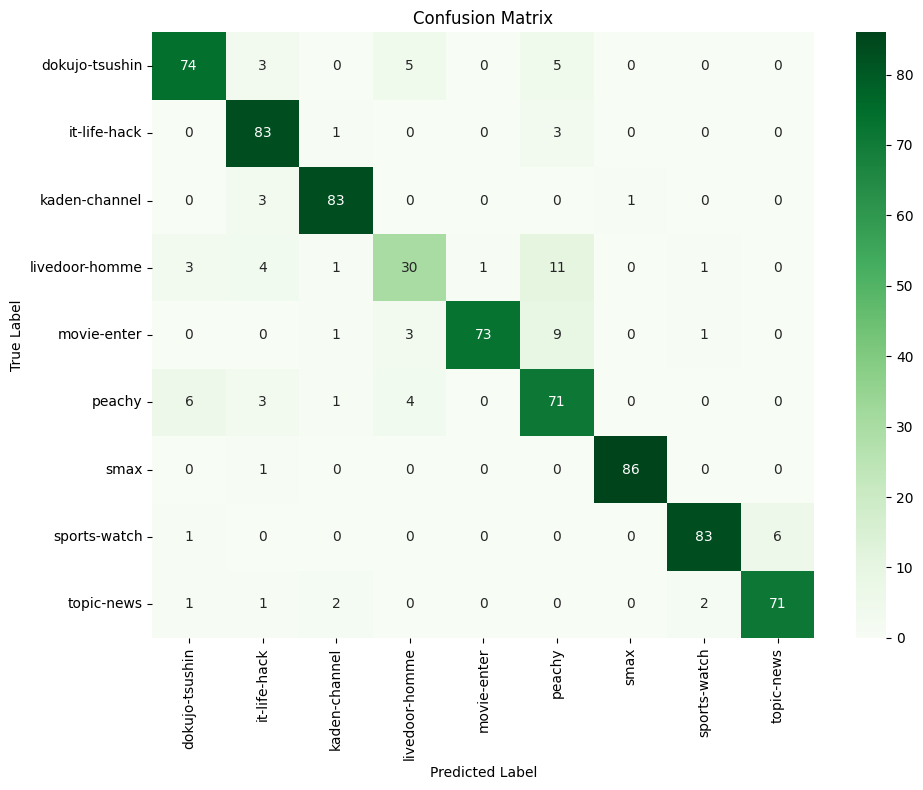

In [22]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 準備 ---
# 学習済みモデルをロードし、deviceに転送
# model.load_state_dict(torch.load('best_model.pth')) # 例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import pickle

# preprocess.pyで保存したpklファイルのパスを指定
# Google Driveに保存した場合は、'/content/drive/MyDrive/...' のようなパスになります
# PKL_FILE_PATH = '/content/drive/MyDrive/deeplearning/processed_data.pkl'

# pklファイルを読み込む
print(f"'{PKL_FILE_PATH}' を読み込んでいます...")
with open(PKL_FILE_PATH, 'rb') as f:
    data = pickle.load(f)

# pklファイル内のデータからid_to_label辞書を再取得
id_to_label = data['id_to_label']

# 評価レポート用に、カテゴリ名のリストもここから作成しておく
category_names = list(id_to_label.values())


# 予測結果と正解ラベルを格納するリスト
all_preds = []
all_labels = []

# --- 評価モード ---
model.eval()
with torch.no_grad():
    for x,t in test_loader: # test_loaderを使用
        # データをdeviceに転送
        x = x.to(device)
        t = t.to(device)

        # モデルの出力を取得
        output = model(x)

        # 予測ラベルを計算 (argmaxで最も確率の高いクラスを取得)
        pred = output.argmax(dim=1)

        # 予測結果と正解ラベルをリストに追加
        # scikit-learnで計算するために、GPU上のTensorからCPU上のnumpy配列に変換
        all_preds.extend(pred.cpu().tolist())
        all_labels.extend(t.cpu().tolist())

# --- 評価指標の計算 (scikit-learnを使用) ---
# 正解率
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")


# 適合率、再現率、F1スコアを含む詳細レポート
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=category_names)
print(report)

# -------------テキストファイルへの保存--------------------
with open("test_results.txt", "w") as f:
  f.write(f"Accuracy: {accuracy:.4f}\n")
  f.write("\nClassification Report:\n")
  f.write(report)

print("\nTest results saved to test_results.txt")

# --- 混同行列の可視化 ---
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)

# DataFrameに変換すると、軸ラベルが見やすくなる
cm_df = pd.DataFrame(cm, index=category_names, columns=category_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout() # ラベルが切れないように調整

#-------------混同行列の画像ファイルへの保存------------

plt.savefig("confusion_matrix.png")
print("\nConfusion matrix saved to confusion_matrix.png")

plt.show()

In [23]:
# (評価ループで all_preds リストを作成した後に...)

# 予測結果をNumPyファイルとして保存
np.save('attention_predictions.npy', np.array(all_preds))
print("Attentionモデルの予測結果を attention_predictions.npy として保存しました。")

Attentionモデルの予測結果を attention_predictions.npy として保存しました。
